<a href="https://colab.research.google.com/github/mirpouya/TensorFlow-Tutorial/blob/main/Convolutional_Neural_Net_Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Dense, InputLayer, MaxPool2D, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
dataset, dataset_info = tfds.load("malaria", with_info=True, as_supervised=True, shuffle_files=True, split=["train"])

In [3]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

it's a dictionary

In [4]:
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

In [5]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  # print(f"data set size: {DATASET_SIZE}")

  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))
  # print(f"train dataset: {train_dataset}")

  val_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE)).take(int(VAL_RATIO * DATASET_SIZE))
  # print(f"val dataset: {val_dataset}")

  test_dataset = dataset.skip(int((TRAIN_RATIO + VAL_RATIO) * DATASET_SIZE))
  # print(f"test_dataset: {val_dataset}")

  return train_dataset, val_dataset, test_dataset

In [6]:
train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [7]:
IM_SIZE = 224

def resizing_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE)) / 255.0, label

In [8]:
train_dataset = train_dataset.map(resizing_rescale)

In [9]:
val_dataset = val_dataset.map(resizing_rescale)

In [10]:
test_dataset = test_dataset.map(resizing_rescale)

In [11]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [12]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [14]:
test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [25]:
from keras.api._v2.keras import activations
model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 5, strides = 1, padding = "valid", activation = "relu"),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = "valid", activation = "relu"),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    Dense(100, activation = "relu"),
    BatchNormalization(),

    Dense(10, activation = "relu"),
    BatchNormalization(),

    Dense(1, activation = "sigmoid")

])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 batch_normalization_4 (Bat  (None, 220, 220, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 110, 110, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_5 (Bat  (None, 106, 106, 16)      64        
 chNormalization)                                                
                                                      

In [26]:
model.compile(optimizer = Adam(learning_rate = 0.08),
              loss = BinaryCrossentropy(),
              metrics = "accuracy")

In [28]:
history = model.fit(train_dataset, validation_data = val_dataset, epochs = 10, verbose = 1)

Epoch 1/10
603/603 [==============================] - 41s 67ms/step - loss: 0.3873 - accuracy: 0.8388 - val_loss: 0.3351 - val_accuracy: 0.9098
Epoch 2/10
603/603 [==============================] - 48s 79ms/step - loss: 0.4967 - accuracy: 0.7456 - val_loss: 1.0216 - val_accuracy: 0.4972
Epoch 3/10
603/603 [==============================] - 47s 78ms/step - loss: 0.4437 - accuracy: 0.8025 - val_loss: 0.6752 - val_accuracy: 0.8369
Epoch 4/10
603/603 [==============================] - 40s 66ms/step - loss: 0.2606 - accuracy: 0.9059 - val_loss: 0.5065 - val_accuracy: 0.7501
Epoch 5/10
603/603 [==============================] - 41s 68ms/step - loss: 0.2123 - accuracy: 0.9295 - val_loss: 0.2245 - val_accuracy: 0.9301
Epoch 6/10
603/603 [==============================] - 47s 78ms/step - loss: 0.1933 - accuracy: 0.9362 - val_loss: 0.1656 - val_accuracy: 0.9479
Epoch 7/10
603/603 [==============================] - 47s 78ms/step - loss: 0.1821 - accuracy: 0.9418 - val_loss: 0.3077 - val_accuracy:

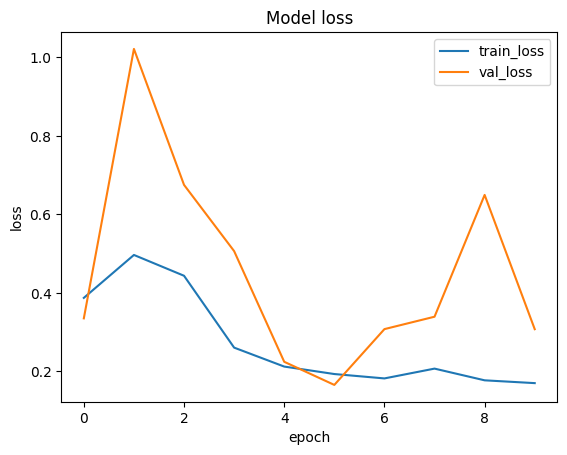

In [29]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "val_loss"])
plt.show()

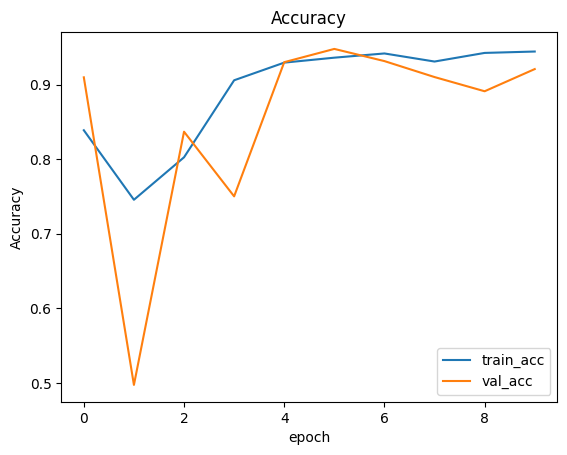

In [30]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.legend(["train_acc", "val_acc"])
plt.show()